In [99]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
* File       : train.ipynb
* Created    : 2023-09-19 10:51:02
* Author     : M0nk3y
* Version    : 1.0
'''
%load_ext autoreload
%autoreload 2

from dataLoder import *
from models import *
import json
from utils import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ASCAD N0=0 
读取JSON文件

In [100]:
with open('./model_settings.json', 'r') as f:
    settings = json.load(f)
settings = settings['ASCAD_N0']
print(settings)
globals().update(settings)

{'model_name': 'ASCAD_N0', 'batch_size': 50, 'learning_rate': 0.005, 'use_1cycle': 'True', 'input_size': 700, 'classes': 256, 'epochs': 50}


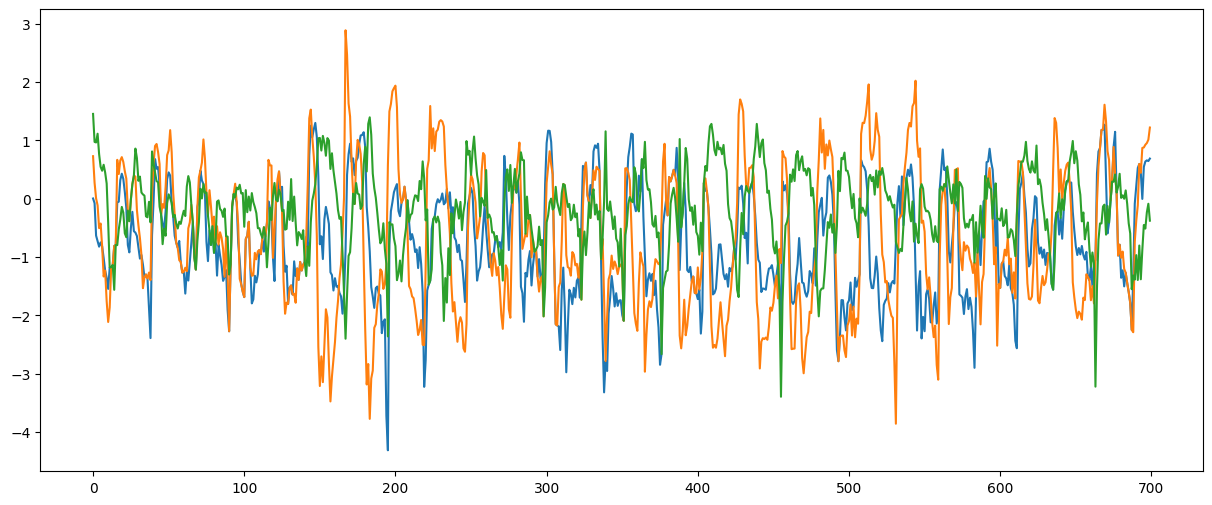

In [101]:
dataloder = DataLoder("./datasets/ASCAD_N0/ASCAD.h5")
X_profiling, Y_profiling, profiling_targets, profiling_key, X_attack, attack_targets, attack_key = dataloder.get_ascad_n0()


# 数据预处理
X_profiling, X_attack = feature_standardization(X_profiling, X_attack)
Reshape_X_train = fit_cnn(X_profiling)
Reshape_X_attack = fit_cnn(X_attack)
# plt
fig = plt.figure(figsize=(15,6))
x = range(X_profiling.shape[1])
for i in range(3):
    plt.plot(x, X_profiling[i])

X_train, X_val, Y_train, Y_val = train_test_split(Reshape_X_train, Y_profiling, test_size=0.1)


模型配置

In [102]:
model = simple_ascad_n0(input_size=Reshape_X_train.shape[1], learning_rate=learning_rate, classes=classes)
model.summary()

Model: "simple_ascad_n0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 700, 1)]          0         
                                                                 
 block1_pool1 (AveragePoolin  (None, 350, 1)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 350)               0         
                                                                 
 fc1 (Dense)                 (None, 10)                3510      
                                                                 
 fc2 (Dense)                 (None, 10)                110       
                                                                 
 fc3 (Dense)                 (None, 256)               2816      
                                                   

In [103]:

# 保存model
model_path = './models/simple_ascad_0.hdf5'
checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=False)
callbacks = [checkpoint]
if use_1cycle == "True":
    lr_manager = OneCycleLR(max_lr=learning_rate, batch_size=batch_size, samples=X_profiling.shape[0], end_percentage=0.2, scale_percentage=0.1, maximum_momentum=None, minimum_momentum=None, verbose=True)
    callbacks.append(lr_manager)
history = model.fit(x=X_train, y=to_categorical(Y_train, 256), validation_data=(X_val, to_categorical(Y_val, 256)), batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks)

ValueError: Data cardinality is ambiguous:
  x sizes: 50000
  y sizes: 45000
Make sure all arrays contain the same number of samples.

In [ ]:
n_traces = 400
n_attack = 100
interval = 1

In [ ]:
predictions = model.predict(Reshape_X_attack, verbose=1)
predictions = np.log(predictions + 1e-40)

# 计算rank
ranks = np.zeros((n_attack, int(n_traces / interval)))
for i in range(n_attack):
    ranks[i] = rank(predictions=predictions, key=attack_key, targets=attack_targets, interval=interval, num_traces=n_traces)

313/313 [==============================] - 0s 398us/step


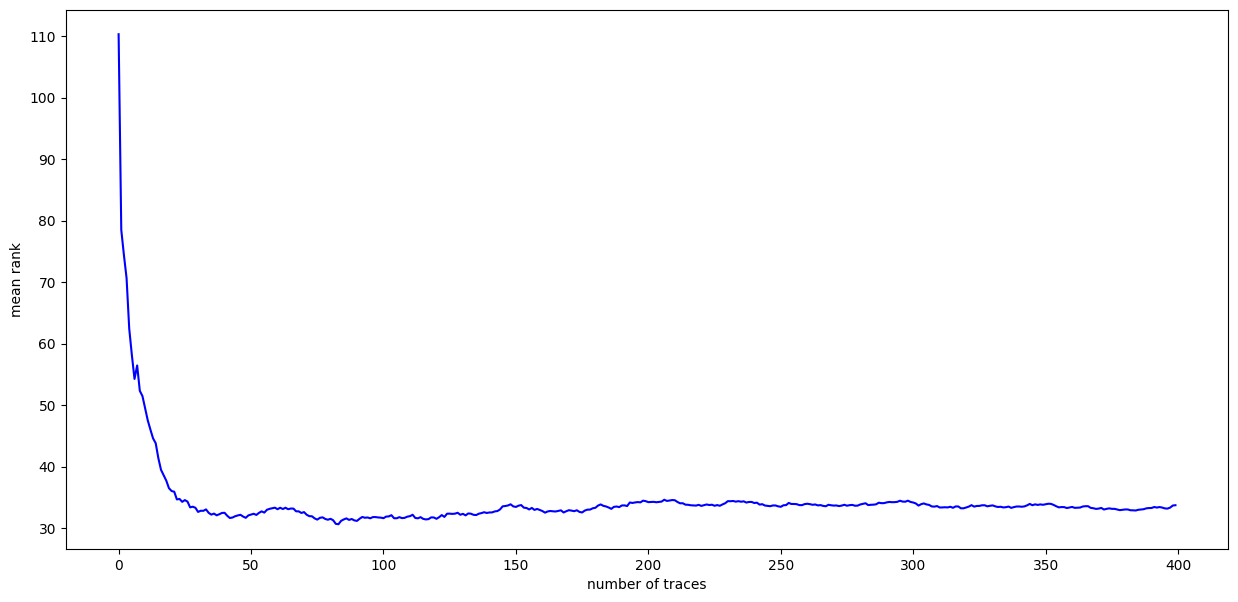

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
x = [x for x in range(0, n_traces, interval)]
ax.plot(x, np.mean(ranks, axis=0), 'b')

ax.set(xlabel="number of traces", ylabel="mean rank")
plt.show()